# OpenPoseの推論
学習済みモデルをロードして推論を実装する

## Library

In [5]:
from PIL import Image
import cv2
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [16]:
from utils.openpose_net import OpenPoseNet

# 学習済みモデルと本性のモデルでネットワークの層の名前が違うので対応させてロードする
# 外枠を作って
net = OpenPoseNet()
# 学習済みパラメータのロード
# net_weights = torch.load('./weights/openpose_net_2.pth', map_location={'cuda:0':'cpu'})
net_weights = torch.load('./weights/pose_model_scratch.pth', map_location={'cuda:0':'cpu'})
keys = list(net_weights.keys())  # 層の名前をリストにする
weights_load = {}

# ロードした内容を本書で構築したモデルのパラメータ名net.state_dict().keys()にコピーする
for i in range(len(keys)):
    weights_load[list(net.state_dict().keys())[i]] = net_weights[list(keys)[i]]  # 層の名前をコピーしている
    
# コピーした内容をモデルに与える
state = net.state_dict()
state.update(weights_load)
net.load_state_dict(state)

print('ネットワーク設定完了　：　学習済みの重みをロードしました')

ネットワーク設定完了　：　学習済みの重みをロードしました


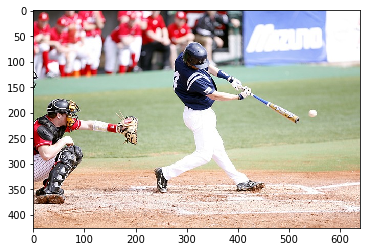

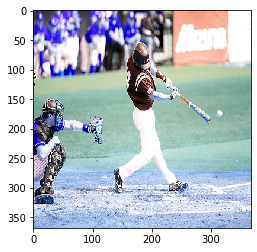

In [17]:
# 草野球の画像を読み込み前処理する
test_image = './data/hit-1407826_640.jpg'
oriImg = cv2.imread(test_image)  # B, G, R

oriImg = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)
plt.imshow(oriImg)
plt.show()

# 画像のリサイズ
size = (368, 368)
img = cv2.resize(oriImg, size, interpolation=cv2.INTER_CUBIC)

# 前処理
# 正規化
img = img.astype(np.float32) / 255.
# 色の標準化
color_mean = [0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]
preprocessed_img = img.copy()[:,:,::-1]  # BGR->RGB  すでになっているのではないのか？

# やっぱおかしい。　一旦これでやってみてもう一度上の1行無しでやってみる
plt.imshow(preprocessed_img)
plt.show()


for i in range(3):
    preprocessed_img[:,:,i] = preprocessed_img[:,:,i] - color_mean[i]
    preprocessed_img[:,:,i] = preprocessed_img[:,:,i] / color_std[i]
    
# 高さ、幅、色　-> 色、高さ、幅
img = preprocessed_img.transpose((2, 0, 1)).astype(np.float32)

# 画像をtensorに
img = torch.from_numpy(img)

# ミニバッチ化
x = img.unsqueeze(0)
# torch.size([1, 3, 368, 368])

In [18]:
# OpenPoseでheatmapとPAFsを求める
net.eval()
predicted_outputs, _ = net(x)  # _ は saved_for_loss　　predicted_outputsは（out6_1, out6_2）

# 画像をtensorからnumpyに変化し、サイズを戻す
pafs = predicted_outputs[0][0].detach().numpy().transpose(1, 2, 0)
heatmaps = predicted_outputs[1][0].detach().numpy().transpose(1, 2, 0)

pafs = cv2.resize(pafs, size, interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, size, interpolation=cv2.INTER_CUBIC)

pafs = cv2.resize(pafs, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

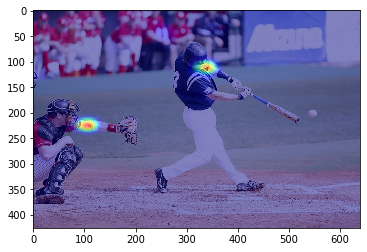

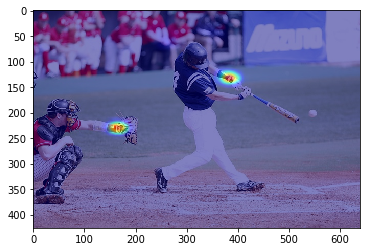

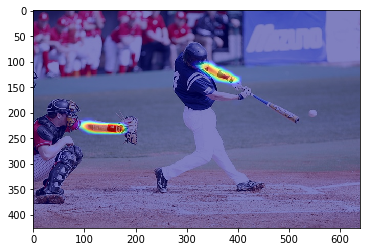

In [19]:
# 左肘と左手首のheatmap, 左肘と左手首をつなぐPAFのxベクトルを可視化する
# 左肘
heat_map = heatmaps[:, :, 6]
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))  # jetっていうカラーマップで
heat_map = np.asarray(heat_map.convert('RGB'))

# 合成して表示
blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

# 左手首
heat_map = heatmaps[:, :, 7]
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))  # jetっていうカラーマップで
heat_map = np.asarray(heat_map.convert('RGB'))

# 合成して表示
blend_img = cv2.addWeighted(oriImg, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

# 左肘と左手首をつなぐPAFのxベクトル
paf = pafs[:,:,24]
paf = Image.fromarray(np.uint8(cm.jet(paf)*255))  # jetっていうカラーマップで
paf = np.asarray(paf.convert('RGB'))

# 合成して表示
blend_img = cv2.addWeighted(oriImg, 0.5, paf, 0.5, 0)
plt.imshow(blend_img)
plt.show()

# 自分のモデルじゃ全く学習されていないってことなんだろうか
# 学習済みモデルをダウンロードしてきてもう一度やってみる
# 学習済みモデルでうまくheatmapとpafが表示できた

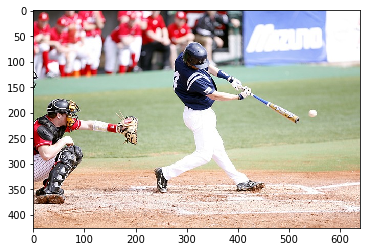

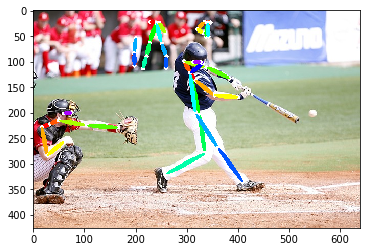

In [20]:
# 各人物の各部位をつなぐリンクを求め描画する
from utils.decode_pose import decode_pose
_, result_img, _, _ = decode_pose(oriImg, heatmaps, pafs)

plt.imshow(oriImg)
plt.show()

plt.imshow(result_img)
plt.show()

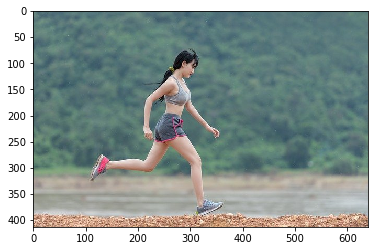

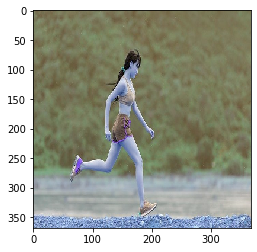

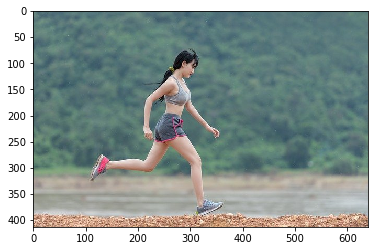

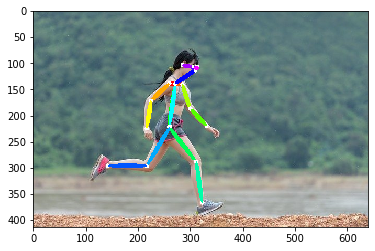

In [21]:
# 他の画像でもやってみる
# 草野球の画像を読み込み前処理する
test_image = './data/woman-1822459_640.jpg'
oriImg = cv2.imread(test_image)  # B, G, R

oriImg = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)
plt.imshow(oriImg)
plt.show()

# 画像のリサイズ
size = (368, 368)
img = cv2.resize(oriImg, size, interpolation=cv2.INTER_CUBIC)

# 前処理
# 正規化
img = img.astype(np.float32) / 255.
# 色の標準化
color_mean = [0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]
preprocessed_img = img.copy()[:,:,::-1]  # BGR->RGB  すでになっているのではないのか？

# やっぱおかしい。　一旦これでやってみてもう一度上の1行無しでやってみる
plt.imshow(preprocessed_img)
plt.show()


for i in range(3):
    preprocessed_img[:,:,i] = preprocessed_img[:,:,i] - color_mean[i]
    preprocessed_img[:,:,i] = preprocessed_img[:,:,i] / color_std[i]
    
# 高さ、幅、色　-> 色、高さ、幅
img = preprocessed_img.transpose((2, 0, 1)).astype(np.float32)

# 画像をtensorに
img = torch.from_numpy(img)

# ミニバッチ化
x = img.unsqueeze(0)
# torch.size([1, 3, 368, 368])

# OpenPoseでheatmapとPAFsを求める
net.eval()
predicted_outputs, _ = net(x)  # _ は saved_for_loss　　predicted_outputsは（out6_1, out6_2）

# 画像をtensorからnumpyに変化し、サイズを戻す
pafs = predicted_outputs[0][0].detach().numpy().transpose(1, 2, 0)
heatmaps = predicted_outputs[1][0].detach().numpy().transpose(1, 2, 0)

pafs = cv2.resize(pafs, size, interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, size, interpolation=cv2.INTER_CUBIC)

pafs = cv2.resize(pafs, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)


from utils.decode_pose import decode_pose
_, result_img, _, _ = decode_pose(oriImg, heatmaps, pafs)

plt.imshow(oriImg)
plt.show()

plt.imshow(result_img)
plt.show()

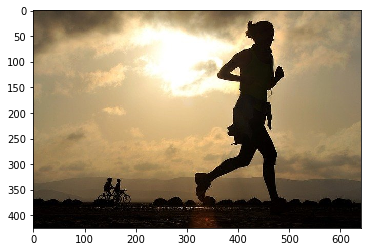

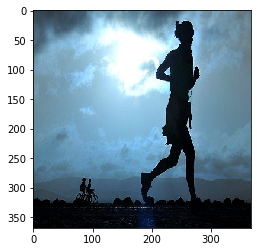

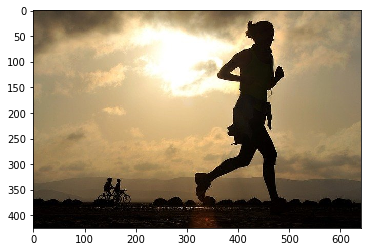

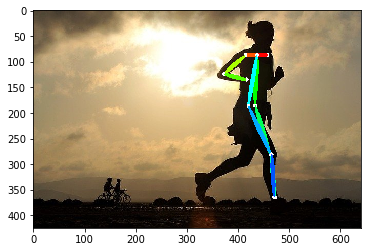

In [22]:
# 他の画像でもやってみる
# 影っぽい画像でもできるか
test_image = './data/running-1705716_640.jpg'
oriImg = cv2.imread(test_image)  # B, G, R

oriImg = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)
plt.imshow(oriImg)
plt.show()

# 画像のリサイズ
size = (368, 368)
img = cv2.resize(oriImg, size, interpolation=cv2.INTER_CUBIC)

# 前処理
# 正規化
img = img.astype(np.float32) / 255.
# 色の標準化
color_mean = [0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]
preprocessed_img = img.copy()[:,:,::-1]  # BGR->RGB  すでになっているのではないのか？

# やっぱおかしい。　一旦これでやってみてもう一度上の1行無しでやってみる
plt.imshow(preprocessed_img)
plt.show()


for i in range(3):
    preprocessed_img[:,:,i] = preprocessed_img[:,:,i] - color_mean[i]
    preprocessed_img[:,:,i] = preprocessed_img[:,:,i] / color_std[i]
    
# 高さ、幅、色　-> 色、高さ、幅
img = preprocessed_img.transpose((2, 0, 1)).astype(np.float32)

# 画像をtensorに
img = torch.from_numpy(img)

# ミニバッチ化
x = img.unsqueeze(0)
# torch.size([1, 3, 368, 368])

# OpenPoseでheatmapとPAFsを求める
net.eval()
predicted_outputs, _ = net(x)  # _ は saved_for_loss　　predicted_outputsは（out6_1, out6_2）

# 画像をtensorからnumpyに変化し、サイズを戻す
pafs = predicted_outputs[0][0].detach().numpy().transpose(1, 2, 0)
heatmaps = predicted_outputs[1][0].detach().numpy().transpose(1, 2, 0)

pafs = cv2.resize(pafs, size, interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, size, interpolation=cv2.INTER_CUBIC)

pafs = cv2.resize(pafs, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)


from utils.decode_pose import decode_pose
_, result_img, _, _ = decode_pose(oriImg, heatmaps, pafs)

plt.imshow(oriImg)
plt.show()

plt.imshow(result_img)
plt.show()

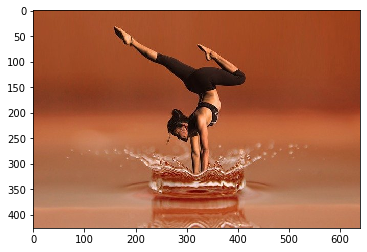

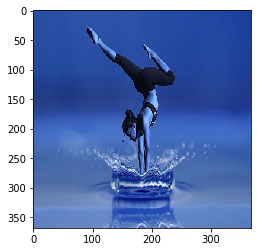

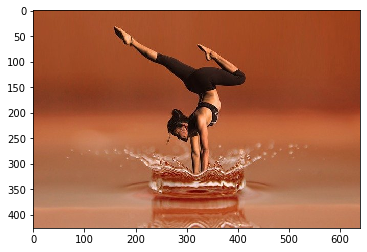

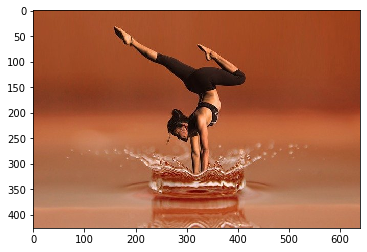

In [23]:
# 普通の人とは逆向きでもできるか
# できなかったなんでだろう
test_image = './data/dance-3134828_640.jpg'
oriImg = cv2.imread(test_image)  # B, G, R

oriImg = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)
plt.imshow(oriImg)
plt.show()

# 画像のリサイズ
size = (368, 368)
img = cv2.resize(oriImg, size, interpolation=cv2.INTER_CUBIC)

# 前処理
# 正規化
img = img.astype(np.float32) / 255.
# 色の標準化
color_mean = [0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]
preprocessed_img = img.copy()[:,:,::-1]  # BGR->RGB  すでになっているのではないのか？

# やっぱおかしい。　一旦これでやってみてもう一度上の1行無しでやってみる
plt.imshow(preprocessed_img)
plt.show()


for i in range(3):
    preprocessed_img[:,:,i] = preprocessed_img[:,:,i] - color_mean[i]
    preprocessed_img[:,:,i] = preprocessed_img[:,:,i] / color_std[i]
    
# 高さ、幅、色　-> 色、高さ、幅
img = preprocessed_img.transpose((2, 0, 1)).astype(np.float32)

# 画像をtensorに
img = torch.from_numpy(img)

# ミニバッチ化
x = img.unsqueeze(0)
# torch.size([1, 3, 368, 368])

# OpenPoseでheatmapとPAFsを求める
net.eval()
predicted_outputs, _ = net(x)  # _ は saved_for_loss　　predicted_outputsは（out6_1, out6_2）

# 画像をtensorからnumpyに変化し、サイズを戻す
pafs = predicted_outputs[0][0].detach().numpy().transpose(1, 2, 0)
heatmaps = predicted_outputs[1][0].detach().numpy().transpose(1, 2, 0)

pafs = cv2.resize(pafs, size, interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, size, interpolation=cv2.INTER_CUBIC)

pafs = cv2.resize(pafs, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)


from utils.decode_pose import decode_pose
_, result_img, _, _ = decode_pose(oriImg, heatmaps, pafs)

plt.imshow(oriImg)
plt.show()

plt.imshow(result_img)
plt.show()

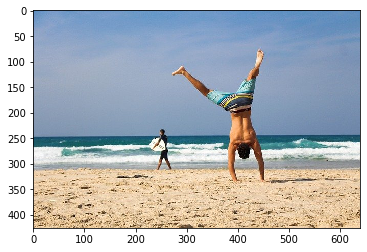

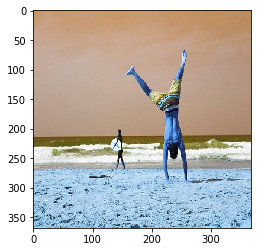

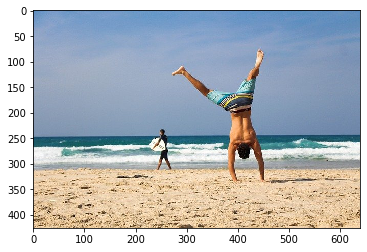

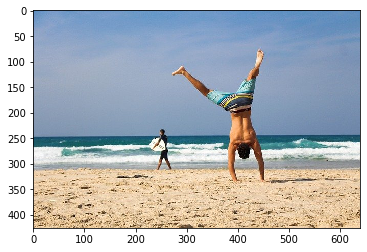

In [24]:

# 普通の人とは逆向きでもできるか
# できなかったなんでだろう
test_image = './data/handstand-2224104_640.jpg'
oriImg = cv2.imread(test_image)  # B, G, R

oriImg = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)
plt.imshow(oriImg)
plt.show()

# 画像のリサイズ
size = (368, 368)
img = cv2.resize(oriImg, size, interpolation=cv2.INTER_CUBIC)

# 前処理
# 正規化
img = img.astype(np.float32) / 255.
# 色の標準化
color_mean = [0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]
preprocessed_img = img.copy()[:,:,::-1]  # BGR->RGB  すでになっているのではないのか？

# やっぱおかしい。　一旦これでやってみてもう一度上の1行無しでやってみる
plt.imshow(preprocessed_img)
plt.show()


for i in range(3):
    preprocessed_img[:,:,i] = preprocessed_img[:,:,i] - color_mean[i]
    preprocessed_img[:,:,i] = preprocessed_img[:,:,i] / color_std[i]
    
# 高さ、幅、色　-> 色、高さ、幅
img = preprocessed_img.transpose((2, 0, 1)).astype(np.float32)

# 画像をtensorに
img = torch.from_numpy(img)

# ミニバッチ化
x = img.unsqueeze(0)
# torch.size([1, 3, 368, 368])

# OpenPoseでheatmapとPAFsを求める
net.eval()
predicted_outputs, _ = net(x)  # _ は saved_for_loss　　predicted_outputsは（out6_1, out6_2）

# 画像をtensorからnumpyに変化し、サイズを戻す
pafs = predicted_outputs[0][0].detach().numpy().transpose(1, 2, 0)
heatmaps = predicted_outputs[1][0].detach().numpy().transpose(1, 2, 0)

pafs = cv2.resize(pafs, size, interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, size, interpolation=cv2.INTER_CUBIC)

pafs = cv2.resize(pafs, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)


from utils.decode_pose import decode_pose
_, result_img, _, _ = decode_pose(oriImg, heatmaps, pafs)

plt.imshow(oriImg)
plt.show()

plt.imshow(result_img)
plt.show()

In [ ]:
# 横向きの画像ならできるだろうか
